# Circuit from YAML

Sometimes it’s useful to be able to define circuits from YAML definitions. To not re-invent the wheel, SAX uses GDSFactory’s YAML netlist spec to define its circuits. This makes it very easy to convert a GDSFactory layout to a SAX circuit model!

In [1]:
import sax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## MZI

Let’s first see how we can define a SAX circuit from YAML:

In [2]:
netlist = """
instances:
    lft:
      component: coupler
      settings:
          coupling: 0.5
    rgt:
        component: coupler
        settings:
            coupling: 0.5
    top:
        component: straight
        settings:
            length: 25.0
    btm:
        component: straight
        settings:
            length: 15.0

connections:
    lft,out0: btm,in0
    btm,out0: rgt,in0
    lft,out1: top,in0
    top,out0: rgt,in1

ports:
    in0:  lft,in0
    in1:  lft,in1
    out0: rgt,out0
    out1: rgt,out1

"""

In [3]:
mzi = sax.circuit_from_yaml(netlist)

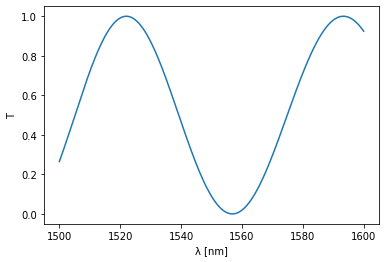

In [4]:
wl = jnp.linspace(1.5, 1.6, 1000)
params = sax.get_params(mzi)
params = sax.set_params(params, wl=wl)
transmission = jnp.abs(mzi(**params)["in0", "out0"]) ** 2

plt.plot(wl * 1e3, transmission)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

That was easy! However, during the above YAML conversion, only models available in sax.models were used. What if we want to map the YAML component names to custom models? Let’s say we want to use a dispersionless waveguide for the above model for example:

In [5]:
def waveguide_without_dispersion(wl=1.55, length=25.0, neff=2.34):
    phase = 2 * jnp.pi * neff * length / wl
    sdict = sax.reciprocal({("in0", "out0"): jnp.exp(1j * phase)})
    return sdict

We can regenerate the above circuit again, but this time we specify a models mapping:

In [6]:
mzi = sax.circuit_from_yaml(netlist, models={"straight": waveguide_without_dispersion})

The models= keyword in circuit_from_yaml can be a dictionary or an imported python module (like for example sax.models). Or a list containing multiple of such dictionary mappings and imported modules.

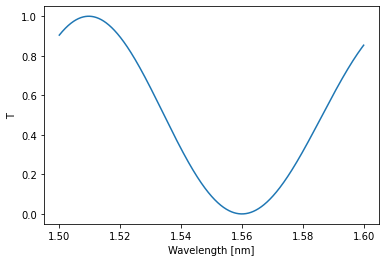

In [7]:
wl = jnp.linspace(1.5, 1.6, 1000)
params = sax.get_params(mzi)
params = sax.set_params(params, wl=wl)
transmission = jnp.abs(mzi(**params)["in0", "out0"]) ** 2

plt.plot(wl, transmission)
plt.xlabel("Wavelength [nm]")
plt.ylabel("T")
plt.show()


## Compatibility with GDSFactory

GDSFactory is an python-based photonic layout tool. 
We can now use the above introduced yaml definition as a translation layer between SAX and GDSFactory:

Let’s start from GDSFactory’s default mzi:

2022-01-02 10:03:38.690 | INFO     | gdsfactory.config:<module>:51 - 3.9.12
2022-01-02 10:03:39.677 | INFO     | gdsfactory.show:show:40 - Klayout show mzi_d41d8cd9: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references


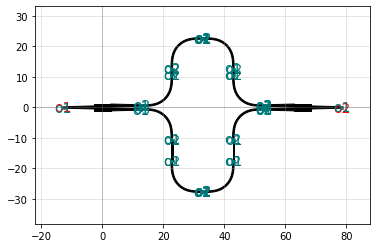

mzi_d41d8cd9: uid 3, ports ['o1', 'o2'], aliases [], 0 polygons, 20 references

In [8]:
import gdsfactory as gf
mzi_component = gf.components.mzi()
mzi_component

In [9]:
netlist = mzi_component.get_netlist_yaml()
print(netlist)

connections:
  bend_euler_1da190e0_17p875_5p5,o1: mmi1x2_d41d8cd9_0p0_0p0,o2
  bend_euler_1da190e0_17p875_5p5,o2: straight_15a9c8d1_22p75_11p625,o1
  bend_euler_1da190e0_17p875_m5p5,o1: mmi1x2_d41d8cd9_0p0_0p0,o3
  bend_euler_1da190e0_17p875_m5p5,o2: straight_cd61840b_22p75_m14p125,o1
  bend_euler_1da190e0_27p625_17p75,o1: straight_528b9164_32p8_22p625,o1
  bend_euler_1da190e0_27p625_17p75,o2: straight_15a9c8d1_22p75_11p625,o2
  bend_euler_1da190e0_27p625_m22p75,o1: straight_cd61840b_22p75_m14p125,o2
  bend_euler_1da190e0_27p625_m22p75,o2: straight_528b9164_32p8_m27p625,o1
  bend_euler_1da190e0_38p065_17p75,o1: straight_4e82411b_32p895_22p625,o2
  bend_euler_1da190e0_38p065_17p75,o2: straight_15a9c8d1_42p94_11p625,o1
  bend_euler_1da190e0_38p065_m22p75,o1: straight_4e82411b_32p895_m27p625,o2
  bend_euler_1da190e0_38p065_m22p75,o2: straight_cd61840b_42p94_m14p125,o1
  bend_euler_1da190e0_47p815_5p5,o1: straight_15a9c8d1_42p94_11p625,o2
  bend_euler_1da190e0_47p815_5p5,o2: straight_5743d

As you can see from the yaml netlist, there are 3 different kinds of components in this circuit:

-   straight
-   bend_euler
-   mmi1x2

we have a ‘straight’ model in sax.models, but the other two will need to be mapped. Moreover, the port conventions in GDSFactory are different. Let’s first remap the ports of our straight model to match the port-convention in GDSFactory:

In [10]:
netlist = mzi_component.get_netlist_yaml()

In [11]:
straight = sax.rename_ports(sax.models.straight, {"in0": "W0", "out0": "E0"})

Let’s create a model for bend_euler. Let’s stub in a dummy model for now:

In [12]:
def bend_euler(radius=1.0, length=10.0):
    return sax.reciprocal({("W0", "N0"): 0.95})

Let’s also create a model for a 1x2 MMI:

In [13]:
def mmi1x2(length=3.0):
    sdict = sax.reciprocal(
        {
            ("W0", "E0"): 0.5 ** 0.5,
            ("W0", "E1"): 0.5 ** 0.5,
        }
    )
    return sdict

Let’s create our model mapping:

In [14]:
models = {
    "straight": straight,
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
}

We can now import the yaml netlist:

In [15]:
mzi = sax.circuit_from_yaml(netlist, models=models)

ValueError: partial object functools.partial(<function bend_euler at 0x7f8000092040>, cross_section={'function': 'cross_section'}) has incorrect arguments

In [17]:
wl = jnp.linspace(1.5, 1.6, 1000)
params = sax.get_params(mzi)
params = sax.set_params(params, wl=wl)
transmission = jnp.abs(mzi(**params)["o1", "o2"]) ** 2
plt.plot(wl * 1e3, transmission)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

KeyError: ('o1', 'o2')

In [18]:
mzi = sax.circuit_from_gdsfactory(mzi_component, models=models)
wl = jnp.linspace(1.5, 1.6, 1000)
params = sax.get_params(mzi)
params = sax.set_params(params, wl=wl)
transmission = jnp.abs(mzi(**params)["W0", "E0"]) ** 2
plt.plot(wl * 1e3, transmission)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()


ValueError: partial object functools.partial(<function bend_euler at 0x7f8000092040>, cross_section={'function': 'cross_section'}) has incorrect arguments